<a href="https://colab.research.google.com/github/castaned/RNP/blob/main/rn_passwords_evaluacionparcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El presente código busca clasificar una serie de contraseñas en cuanto a su fortaleza. Las contraseñas provienen del 000webhost leak, disponible en
https://www.kaggle.com/bhavikbb/password-strength-classifier-dataset.

El dataset a utilizar presenta 670k valores distribuidos en dos columnas:

password: Contraseña a analizar.

strength: Clasíficación de fuerza de contraseña utilizando parámetros comerciales (0 es débil, 1 es medio, 2 es fuerte). 


In [ ]:
#google colab cuenta con una version de tensorflow instalada; especificamos la version a utilizar (1.x o 2.x)
%tensorflow_version 1.x

#verificamos la version de tensorflow utilizada
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [ ]:
#importamos las librerias necesarias
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
#importamos las funciones necesarias
from sklearn.model_selection import train_test_split             #funcion que separa los datos aleatoriamente en arreglos train/test
from sklearn.preprocessing import MinMaxScaler                   #funcion de rescalamiento de datos segun un factor dado
from sklearn.preprocessing import Normalizer                     #funcion de normalizacion
from matplotlib import pyplot as plt                             #funcion de graficacion
from keras.models import Sequential                              #modelo secuencial de keras
from keras.layers.core import Dense                              #funcion para añadir otra capa en keras
from tensorflow.keras.callbacks import EarlyStopping             #funcion que permite detener el algoritmo si no se percibe un progreso medido con ciertos parametros

Using TensorFlow backend.


In [ ]:
#montamos nuestro google drive para importar archivos
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
#importamos el dataset a utilizar de drive
df = pd.read_csv('/content/drive/My Drive/Classroom/ML/passwords.csv', error_bad_lines=False)

b'Skipping line 2810: expected 2 fields, saw 5\nSkipping line 4641: expected 2 fields, saw 5\nSkipping line 7171: expected 2 fields, saw 5\nSkipping line 11220: expected 2 fields, saw 5\nSkipping line 13809: expected 2 fields, saw 5\nSkipping line 14132: expected 2 fields, saw 5\nSkipping line 14293: expected 2 fields, saw 5\nSkipping line 14865: expected 2 fields, saw 5\nSkipping line 17419: expected 2 fields, saw 5\nSkipping line 22801: expected 2 fields, saw 5\nSkipping line 25001: expected 2 fields, saw 5\nSkipping line 26603: expected 2 fields, saw 5\nSkipping line 26742: expected 2 fields, saw 5\nSkipping line 29702: expected 2 fields, saw 5\nSkipping line 32767: expected 2 fields, saw 5\nSkipping line 32878: expected 2 fields, saw 5\nSkipping line 35643: expected 2 fields, saw 5\nSkipping line 36550: expected 2 fields, saw 5\nSkipping line 38732: expected 2 fields, saw 5\nSkipping line 40567: expected 2 fields, saw 5\nSkipping line 40576: expected 2 fields, saw 5\nSkipping line 

In [ ]:
df.dtypes

password    object
strength     int64
dtype: object

In [ ]:
df.index

RangeIndex(start=0, stop=669640, step=1)

In [ ]:
df.head()

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


In [ ]:
#para aglizar el proceso, seleccionamos solamente los primeros 10000 valores
df = df[0:10000]

Para poder analizar esto mediante una red neuronal con un aprendizaje aceptable, se necesitan al menos 5 features que evaluar. 

A partir de la columna password, se crearan 5 parametros numericos segun las características de cada contraseña:

password_length : número de caracteres.

password_letters : número de letras en la contraseña.

password_numbers : número de números en la contraseña.

password_mayus : número de letras mayusculas en la contraseña.

password_minus : número de letras minusculas en la contraseña.

password_vowels : número de vocales en la contraseña.


In [ ]:
#creamos vector de vocales
vowels = ['a','e','i','o','u']

In [ ]:
#creamos arreglos que almacenen valores de caracteristicas a analizar en cada contraseña
pass_mayus = [] #num. de mayusculas
pass_minus = [] #num. de minusculas
pass_vow   = [] #num. de vocales

for i in range(len(df)):
  password = str(df['password'][i])
  pass_mayus.append(sum(1 for c in password if c.isupper()))
  pass_minus.append(sum(1 for c in password if c.islower()))
  pass_vow.append(sum(password.count(c) for c in vowels ))

In [ ]:
#creamos columnas a partir de las caracteristicas de la columna password
df['password_length'] = df['password'].str.len()       
df['password_letters'] = abs(df['password'].str.len() - df['password'].str.count('\d'))             
df['password_numbers'] = df['password'].str.count('\d')    
df['password_mayus'] = pass_mayus
df['password_minus'] = pass_minus
df['password_vowels'] = pass_vow

In [ ]:
df.head()

,password,strength,password_length,password_letters,password_numbers,password_mayus,password_minus,password_vowels
0,kzde5577,1,8,4,4,0,4,1
1,kino3434,1,8,4,4,0,4,2
2,visi7k1yr,1,9,7,2,0,7,2
3,megzy123,1,8,5,3,0,5,1
4,lamborghin1,1,11,10,1,0,10,3


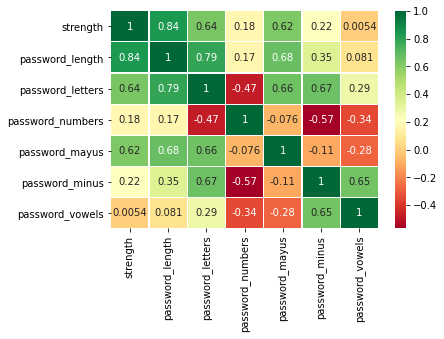

In [ ]:
#se genera un grafico de correlaciones para observar la relacion entre las variables y deducir si es posible eliminar algunas sin perder informacion
fig = sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.1) #df_train.corr()-->correlation matrix

In [ ]:
#eliminamos el parametros de baja correlacion
#cols = ['password_vowels']


#df = df.drop(cols, axis=1)

In [ ]:
#se separan los datos en valores de entrada (features) y los valores de salida (para este caso, el diagnositco)
X_df = df                                                     #features
X_df = X_df.drop(['strength'], axis=1)                        #eliminamos el valor de salida de las features
y_df = df['strength']                                        #vector columna de diagnostico (valor de salida)

In [ ]:
print(y_df.unique())
X_df.head()

[1 2 0]


,password_length,password_letters,password_numbers,password_mayus,password_minus
0,8,4,4,0,4
1,8,4,4,0,4
2,9,7,2,0,7
3,8,5,3,0,5
4,11,10,1,0,10


In [ ]:
#se utiliza la funcion train_test_split para separar los datos aleatoriamente en cuatro sets: dosde entrenamiento (70%) y otros dos de prueba (30%), tanto features como valores de salida

x_tr, x_ts, y_tr, y_ts = train_test_split(X_df, y_df, test_size = 0.3, random_state = 42)   #generacion de arreglos aleatorios de features y valores de salida de entrenamiento y de prueba

y_tr = np.asarray(y_tr, dtype = np.int)   #cambiamos las variables al tipo numpy int
y_ts = np.asarray(y_ts, dtype = np.int)   

y_tr = np.reshape(y_tr, [int(len(df)*0.70),1])          #reacomodamos el arreglo según el numero de valores en el dataset
y_ts = np.reshape(y_ts, [int(len(df)*.30),1])          

print(x_ts.shape)
print(x_tr.shape)
print(y_ts.shape)
print(y_tr.shape)

(3000, 5)
(7000, 5)
(3000, 1)
(7000, 1)


In [ ]:
# Training Data
x_tr = MinMaxScaler().fit_transform(x_tr) #reescalamos el dataframe de valores de entrenamiento como un arreglo de valores entre 0 y 1    
y_tr = MinMaxScaler().fit_transform(y_tr) #reescalamos el dataframe de valores de entrenamiento como un arreglo de valores entre 0 y 1             
print("Training Data :", x_tr.shape)

# Testing Data
x_ts = MinMaxScaler().fit_transform(x_ts) #reescalamos el dataframe de valores de prueba como un arreglo de valores entre 0 y 1   
y_ts = MinMaxScaler().fit_transform(y_ts) #reescalamos el dataframe de valores de prueba como un arreglo de valores entre 0 y 1  
print("Testing Data :", x_ts.shape)

Training Data : (7000, 5)
Testing Data : (3000, 5)


In [ ]:
#print(x_tr,y_tr)
len(X_df.columns)

5

===========Data Summary===========
Training Data : (7000, 5)
Testing Data : (3000, 5)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

============Processing============
Step:     0	Loss: 1.037	Acc: 12.84%
Step:  1000	Loss: 0.684	Acc: 25.79%
Step:  2000	Loss: 0.683	Acc: 26.07%
Step:  3000	Loss: 0.681	Acc: 26.24%
Step:  4000	Loss: 0.680	Acc: 26.33%
Step:  5000	Loss: 0.679	Acc: 26.33%
Step:  6000	Loss: 0.677	Acc: 26.36%
Step:  7000	Loss: 0.675	Acc: 26.36%
Step:  8000	Loss: 0.673	Acc: 26.36%
Step:  9000	Loss: 0.671	Acc: 26.36%
Step: 10000	Loss: 0.669	Acc: 26.36%
Step: 11000	Loss: 0.666	Acc: 26.36%
Step: 12000	Loss: 0.664	Acc: 26.36%
Step: 13000	Loss: 0.661	Acc: 26.36%
Step: 14000	Loss: 0.658	Acc: 26.36%
Step: 15000	Loss: 0.655	Acc: 26.36%
Step: 16000	Loss: 0.651	Acc: 26.36%
Step: 17000	Loss: 0.647	Acc: 26.36%
Step: 18000	Loss: 0.644	Acc: 26.36%
Step: 19000	Loss: 0.640	Acc: 26.36%
Step: 20000	Loss: 0.636	Acc: 26.36%

============Results========

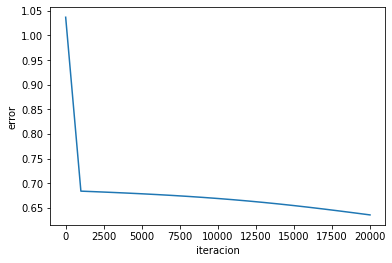

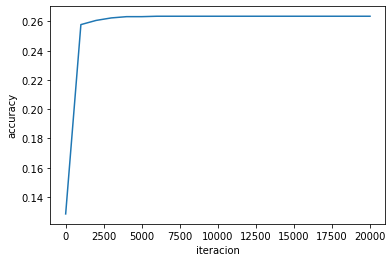

In [ ]:
#realizamos el algoritmo básico de clasificación utilizando tensorflow
print("===========Data Summary===========")
print("Training Data :", x_tr.shape)
print("Testing Data :", x_ts.shape)

num_features = len(X_df.columns)
num_hidden1 = len(X_df.columns)
num_hidden2 = len(X_df.columns)
num_output = 1

X = tf.placeholder(tf.float32, [None, num_features])
Y = tf.placeholder(tf.float32, [None, num_output])

# pesos y biases de la capa de entrada (datos de entrnamiento) a capa oculta 1
W1 = tf.Variable(tf.random_normal([num_features,num_hidden1], seed=0), name='weight1')
b1 = tf.Variable(tf.random_normal([num_hidden1], seed=0), name='bias1')
layer1 = tf.nn.sigmoid(tf.matmul(X,W1) + b1)

# pesos y biases de la capa de entrada (datos de entrnamiento) a capa oculta 2
W2 = tf.Variable(tf.random_normal([num_hidden1,num_hidden2], seed=0), name='weight2')
b2 = tf.Variable(tf.random_normal([num_hidden2], seed=0), name='bias2')
layer2 = tf.nn.sigmoid(tf.matmul(X,W2) + b2)

# pesos y biases de la capa oculta a capa de salida
W3 = tf.Variable(tf.random_normal([num_hidden2,num_output], seed=0), name='weight3')
b3 = tf.Variable(tf.random_normal([num_output], seed=0), name='bias3')
logits = tf.matmul(layer2,W3) + b3

# valor de salida de la red neuronal
hypothesis = tf.nn.sigmoid(logits)
  
# funcion de error 
# x = logits, z = labels     
# sigmoid_cross_entropy = x - x * z + log(1 + exp(-x))
cost_i = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=Y)
cost = tf.reduce_mean(cost_i)

# entrenamiento por descenso de gradientes, factor de aprendizaje 0.01
train = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cost)

# definicion de accuracy, fraccion de aciertos de la red neuronal en una iteracion sobre los datos de entrenamiento
prediction = tf.cast(hypothesis > 0.5, dtype=tf.float32)
correct_prediction = tf.equal(prediction, Y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32))


print("\n============Processing============")
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

#    cost_summary = tf.summary.scalar("error",cost)
#    acc_summary = tf.summary.scalar("acc",accuracy)
    # Merge all summaries
#    all_summary = tf.summary.merge_all()
#    writer = tf.summary.FileWriter("C:/Users/Alfredo/Documents/GitHub/RNP/tensorboard/mlp_breastc_tf", sess.graph)

    
    loss_value = []
    acc_value = []
    itera = []
    for step in range(20001):
        sess.run(train, feed_dict={X: x_tr, Y: y_tr})
        if step % 1000 == 0:
            loss, acc = sess.run([cost, accuracy], feed_dict={X: x_tr, Y: y_tr})
            print("Step: {:5}\tLoss: {:.3f}\tAcc: {:.2%}".format(step, loss, acc))
#            summary_results = sess.run(all_summary,feed_dict={X: x_tr, Y: y_tr})
#            writer.add_summary(summary_results,step)  

            loss_value = np.append(loss_value,loss)
            acc_value = np.append(acc_value,acc)
            itera = np.append(itera,step)
            
    train_acc = sess.run(accuracy, feed_dict={X: x_tr, Y: y_tr})
    test_acc,test_predict,test_correct = sess.run([accuracy,prediction,correct_prediction], feed_dict={X: x_ts, Y: y_ts})
  

    

    print("\n============Results============")
    print("Model Prediction =", train_acc)
    print("Test Prediction =", test_acc)
    
    plt.plot(itera,loss_value)
    plt.ylabel('error')
    plt.xlabel('iteracion')
    plt.show()
    
    plt.plot(itera,acc_value)
    plt.ylabel('accuracy')
    plt.xlabel('iteracion')
    plt.show()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 6         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________
Train on 7000 samples, validate on 3000 samples
Epoch 1/10000
7000/7000 [==============================] - 1s 74us/sample - loss: 0.6977 - acc: 0.1129 - val_loss: 0.6931 - val_acc: 0.1457
Epoch 2/10000
7000/7000 [==============================] - 0s 54us/sample - loss: 0.6939 - acc: 0.1656 - val_loss: 0.6915 - val_acc: 0.1457
Epoch 3/10000
7000/7000 [==============================] - 0

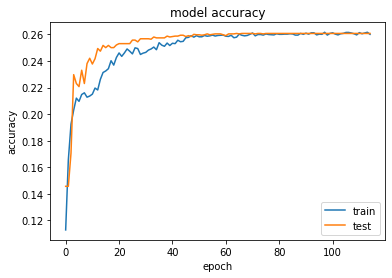

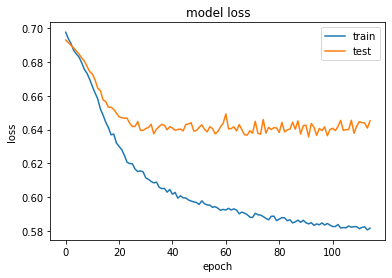

Maximum Loss : 0.6977

Minimum Loss : 0.5806

Loss difference : 0.1171


In [ ]:
#realizamos el algoritmo de clasificacion usando keras

# Hyperparameters
training_epochs = 1000 # Total number of training epochs
learning_rate = 0.1 # The learning rate
hidden_layer1 = len(X_df.columns)
hidden_layer2 = len(X_df.columns)/2

#objetos a utilizar 
early_stopping = EarlyStopping(
    monitor='val_acc', 
    patience=50, 
    min_delta=0.001, 
    mode='max'
)

# create a model
def create_model():
    model = tf.keras.Sequential()
    # Hidden layer 1
    model.add(tf.keras.layers.Dense(hidden_layer1, input_dim=hidden_layer1,activation='sigmoid'))
    model.add(tf.keras.layers.Dropout(0.1))
    # Hidden layer 2
    #model.add(tf.keras.layers.Dense(hidden_layer2, input_dim=hidden_layer1,activation='sigmoid'))
    #model.add(tf.keras.layers.Dropout(0.1))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile a model
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate),
                  metrics=['acc'])
    return model

model = create_model()
model.summary()

results = model.fit(
    x_tr, y_tr,
    epochs= training_epochs,
    validation_data = (x_ts, y_ts),
    verbose = 1,
   callbacks = [early_stopping]
)



print("Evaluating on training set...")
(loss, accuracy) = model.evaluate(x_tr, y_tr, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

print("Evaluating on testing set...")
(loss, accuracy) = model.evaluate(x_ts, y_ts, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("")
print("Minimum Loss : {:.4f}".format(min_loss))
print("")
print("Loss difference : {:.4f}".format((max_loss - min_loss)))